In [1]:
# 0) Imports & setup
import warnings, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    confusion_matrix, classification_report, precision_recall_curve
)

# Models (pure scikit-learn – no external installs needed)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import randint, uniform

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# 1) Load TRAINING data only
TRAIN_PATH = "dataset_B_training.csv"   # <-- ensure the file is here
train = pd.read_csv(TRAIN_PATH)
assert 'respondent_id' in train.columns, "respondent_id missing"
assert 'h1n1_vaccine' in train.columns, "h1n1_vaccine (target) missing"
print("Train shape:", train.shape)

Train shape: (4756, 31)


In [3]:
# 2) EDA essentials (fast & useful)
print("\nTarget balance (counts and %):")
print(train['h1n1_vaccine'].value_counts())
print((train['h1n1_vaccine'].value_counts(normalize=True)*100).round(2).astype(str) + "%")


Target balance (counts and %):
h1n1_vaccine
0    2882
1    1874
Name: count, dtype: int64
h1n1_vaccine
0    60.6%
1    39.4%
Name: proportion, dtype: object



Target balance (counts and %):
h1n1_vaccine
0    2882
1    1874
Name: count, dtype: int64
h1n1_vaccine
0    60.6%
1    39.4%
Name: proportion, dtype: object


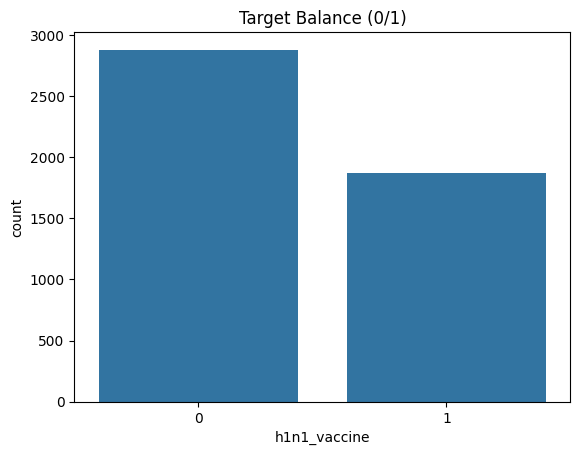

In [4]:
# 2) EDA essentials (fast & useful)
print("\nTarget balance (counts and %):")
print(train['h1n1_vaccine'].value_counts())
print((train['h1n1_vaccine'].value_counts(normalize=True)*100).round(2).astype(str) + "%")

# Target balance plot
sns.countplot(x='h1n1_vaccine', data=train)
plt.title("Target Balance (0/1)")
plt.show()

In [6]:
# Missingness summary
null_rate = train.isna().mean().sort_values(ascending=False)
print("\nTop 15 columns by missing rate:")
print((null_rate.head(15)*100).round(1).astype(str) + "%")


Top 15 columns by missing rate:
employment_sector              49.7%
health_insurance               40.5%
income_poverty                 15.0%
doctor_recc_h1n1                6.7%
rent_or_own                     6.6%
employment_status               4.9%
marital_status                  4.8%
education                       4.7%
chronic_med_condition           3.4%
child_under_6_months            2.8%
health_worker                   2.8%
opinion_h1n1_vacc_effective     1.5%
opinion_h1n1_risk               1.3%
opinion_h1n1_sick_from_vacc     1.3%
household_children              0.7%
dtype: object


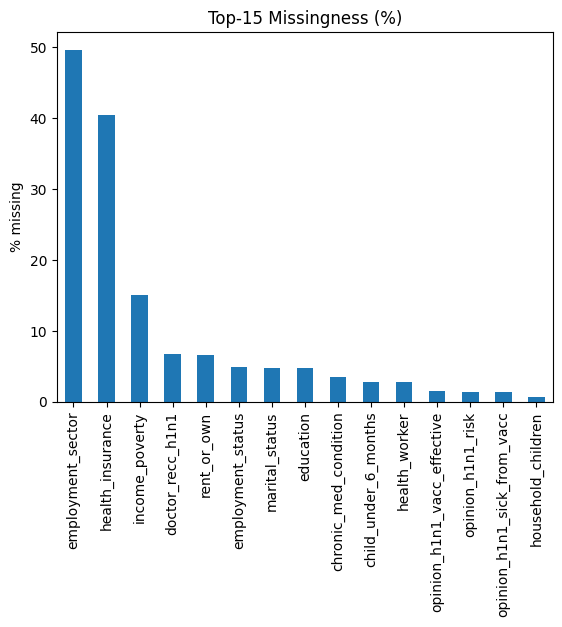

In [7]:
# Visual missingness (top 15)
null_rate.head(15).mul(100).round(1).plot(kind='bar')
plt.title("Top-15 Missingness (%)")
plt.ylabel("% missing")
plt.show()

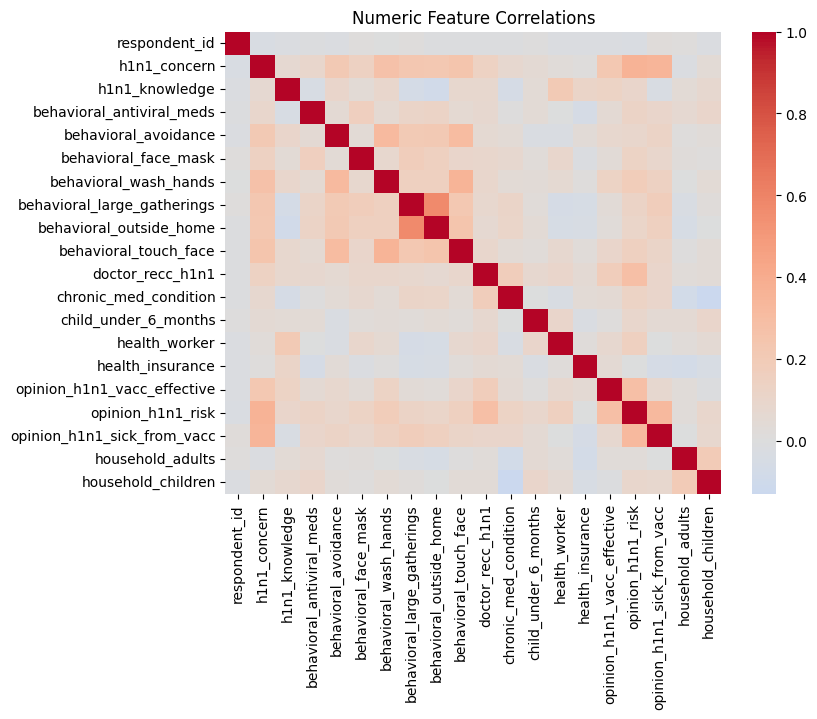

In [8]:
# Quick numeric correlation heatmap (only for numeric columns)
num_only = train.select_dtypes(include=[np.number]).drop(columns=['h1n1_vaccine'], errors='ignore')
if num_only.shape[1] > 1:
    corr = num_only.corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title("Numeric Feature Correlations")
    plt.show()

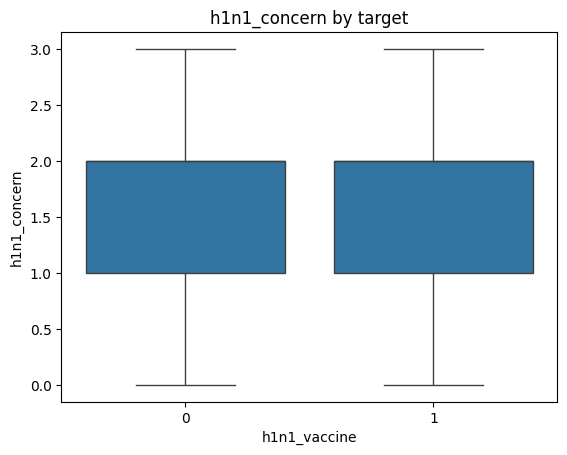

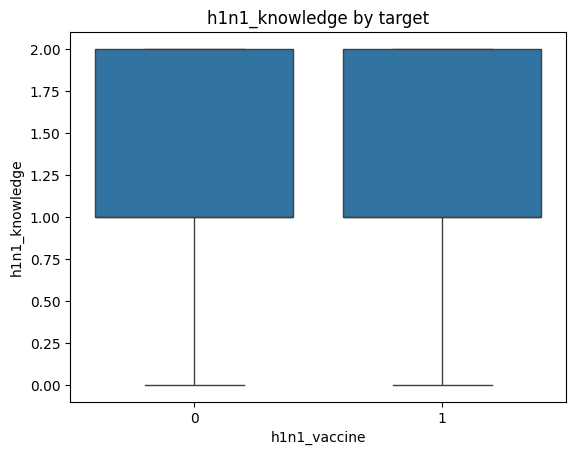

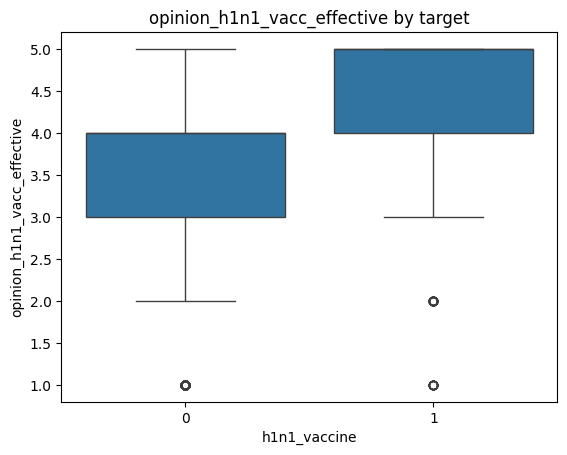

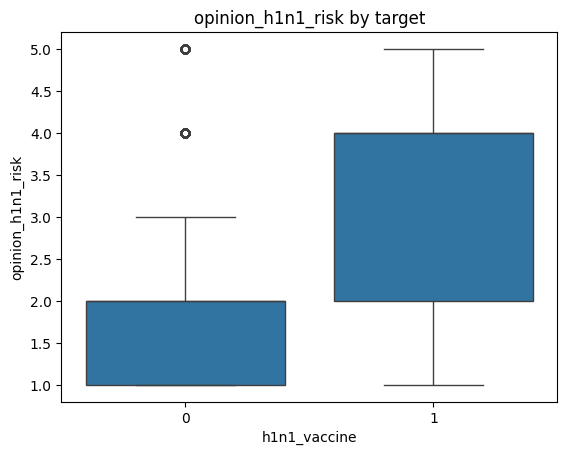

In [9]:
# A few ordinal/opinion variables boxplots vs target (if present)
for col in ['h1n1_concern','h1n1_knowledge','opinion_h1n1_vacc_effective','opinion_h1n1_risk']:
    if col in train.columns:
        sns.boxplot(x='h1n1_vaccine', y=col, data=train)
        plt.title(f"{col} by target")
        plt.show()

In [10]:
# 3) Feature groups (from the provided data dictionary)
cat_cols = [
    'age_group','education','race','sex','income_poverty','marital_status',
    'rent_or_own','employment_status','census_msa','employment_sector'
]
exclude = set(['respondent_id','h1n1_vaccine'] + cat_cols)
num_cols = [c for c in train.columns if c not in exclude]

print("\nCategorical columns:", cat_cols)
print("Numeric/Binary/Ordinal columns:", num_cols)


Categorical columns: ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa', 'employment_sector']
Numeric/Binary/Ordinal columns: ['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'household_adults', 'household_children']


In [11]:
# 4) Split TRAIN into train/valid (stratified)
X = train.drop(columns=['h1n1_vaccine'])
y = train['h1n1_vaccine'].astype(int)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

In [12]:
# 5) Preprocessing pipelines (inside ColumnTransformer → Pipeline)
num_proc = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))  # works with sparse concat
])
cat_proc = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', num_proc, num_cols),
    ('cat', cat_proc, cat_cols)
])


In [14]:
# 6) Models – all sklean variants (no external libs)
models = {
    "logreg": LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE),
    "rf": RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    "extra": ExtraTreesClassifier(n_estimators=600, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    "hgb": HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    "gbc": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "linsvc_cal": CalibratedClassifierCV(
        estimator=LinearSVC(class_weight='balanced', random_state=RANDOM_STATE),
        method='sigmoid', cv=3
    ),
    "dt": DecisionTreeClassifier(max_depth=None, class_weight='balanced', random_state=RANDOM_STATE),
    "knn": KNeighborsClassifier(n_neighbors=15, weights='distance')
}
pipes = {name: Pipeline([('prep', preprocess), ('clf', clf)]) for name, clf in models.items()}

In [15]:
# 7) F1-threshold from precision–recall curve (principled)
def best_f1_threshold_from_scores(y_true, scores):
    """Find threshold that maximizes F1 using precision–recall curve."""
    s = np.asarray(scores, dtype=float)
    # If scores aren’t probabilities, use a rank-based 0..1 mapping (keeps order)
    if (s.min() < 0) or (s.max() > 1):
        ranks = s.argsort().argsort().astype(float)
        s = ranks / max(1, len(s) - 1)
    precision, recall, thr = precision_recall_curve(y_true, s)
    # precision_recall_curve returns N+1 points for N thresholds
    f1s = 2 * (precision[:-1] * recall[:-1]) / np.clip(precision[:-1] + recall[:-1], 1e-9, None)
    i = int(np.nanargmax(f1s))
    return float(thr[i]), float(f1s[i])

def evaluate_on_valid(name, pipe):
    pipe.fit(X_train, y_train)
    if hasattr(pipe['clf'], "predict_proba"):
        scores = pipe.predict_proba(X_valid)[:, 1]
    elif hasattr(pipe['clf'], "decision_function"):
        scores = pipe.decision_function(X_valid)
    else:
        # fallback (hard predictions – rare here)
        y_pred = pipe.predict(X_valid)
        return {
            "name": name, "threshold": 0.5,
            "F1_valid": f1_score(y_valid, y_pred),
            "precision": precision_score(y_valid, y_pred, zero_division=0),
            "recall": recall_score(y_valid, y_pred, zero_division=0),
            "accuracy": accuracy_score(y_valid, y_pred)
        }
    thr, _ = best_f1_threshold_from_scores(y_valid, scores)
    # For generating binary predictions, use the same scores (if probas) at thr
    # If they were decision scores, we already converted to rank-scale inside helper
    # but here we can binarize directly by comparing with thr on probas; for decision scores,
    # re-create the same scaling to be consistent:
    s = np.asarray(scores, dtype=float)
    if (s.min() < 0) or (s.max() > 1):
        ranks = s.argsort().argsort().astype(float)
        s = ranks / max(1, len(s) - 1)
    y_pred = (s >= thr).astype(int)

    return {
        "name": name, "threshold": thr,
        "F1_valid": f1_score(y_valid, y_pred),
        "precision": precision_score(y_valid, y_pred, zero_division=0),
        "recall": recall_score(y_valid, y_pred, zero_division=0),
        "accuracy": accuracy_score(y_valid, y_pred)
    }


Training/Evaluating: logreg
 -> F1=0.6936 | P=0.6786 | R=0.7093 | Acc=0.7532 | thr=0.519

Training/Evaluating: rf
 -> F1=0.6847 | P=0.6341 | R=0.7440 | Acc=0.7300 | thr=0.386

Training/Evaluating: extra
 -> F1=0.6856 | P=0.6658 | R=0.7067 | Acc=0.7447 | thr=0.415

Training/Evaluating: hgb
 -> F1=0.6845 | P=0.6300 | R=0.7493 | Acc=0.7279 | thr=0.337

Training/Evaluating: gbc
 -> F1=0.6928 | P=0.6403 | R=0.7547 | Acc=0.7363 | thr=0.361

Training/Evaluating: linsvc_cal
 -> F1=0.6907 | P=0.6683 | R=0.7147 | Acc=0.7479 | thr=0.404

Training/Evaluating: dt
 -> F1=0.5800 | P=0.5660 | R=0.5947 | Acc=0.6607 | thr=1.000

Training/Evaluating: knn
 -> F1=0.6632 | P=0.6402 | R=0.6880 | Acc=0.7248 | thr=0.398

=== Leaderboard (Validation, F1) ===


,name,threshold,F1_valid,precision,recall,accuracy
0,logreg,0.519146,0.693611,0.678571,0.709333,0.753151
1,gbc,0.360951,0.692778,0.640271,0.754667,0.736345
2,linsvc_cal,0.404145,0.690722,0.668329,0.714667,0.747899
3,extra,0.415000,0.685640,0.665829,0.706667,0.744748
4,rf,0.386000,0.684663,0.634091,0.744000,0.730042
5,hgb,0.336835,0.684531,0.630045,0.749333,0.727941
6,knn,0.397928,0.663239,0.640199,0.688000,0.724790
7,dt,1.000000,0.579974,0.565990,0.594667,0.660714


Saved: leaderboard_validation_f1.csv


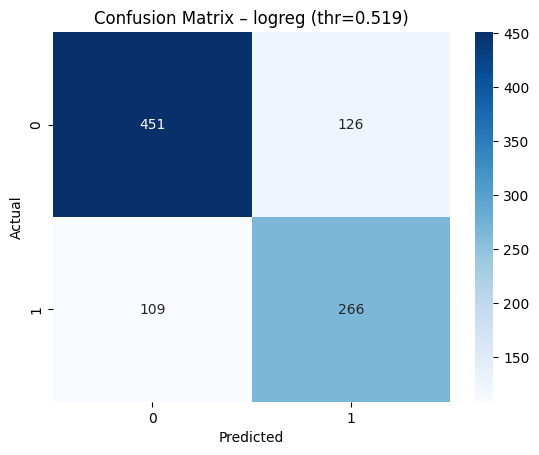

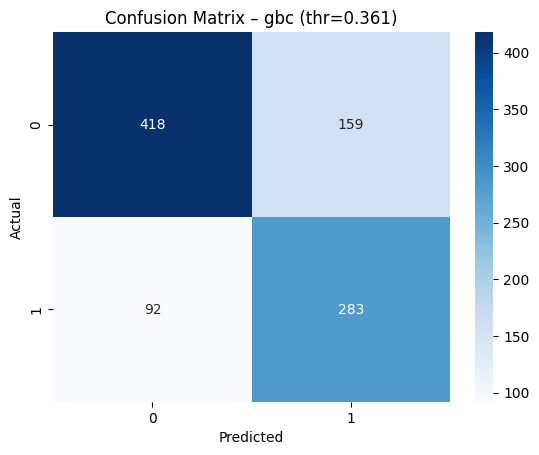

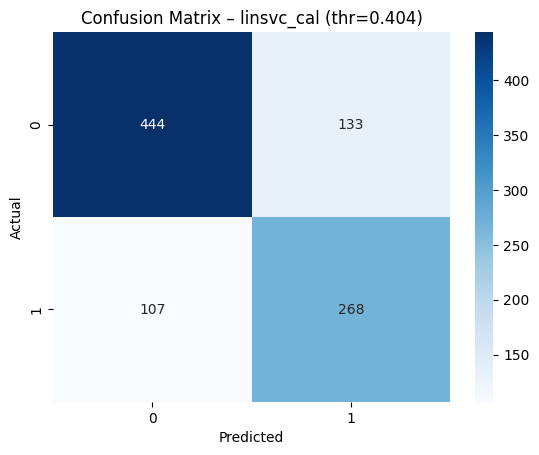

In [17]:
# 8) Train & evaluate all models (F1-focused)
results = []
for name, pipe in pipes.items():
    print(f"\nTraining/Evaluating: {name}")
    res = evaluate_on_valid(name, pipe)
    results.append(res)
    print(f" -> F1={res['F1_valid']:.4f} | P={res['precision']:.4f} | R={res['recall']:.4f} | Acc={res['accuracy']:.4f} | thr={res['threshold']:.3f}")

# Sort by F1 desc and show Leaderboard
results_sorted = sorted(results, key=lambda r: r["F1_valid"], reverse=True)
leaderboard = pd.DataFrame(results_sorted)
print("\n=== Leaderboard (Validation, F1) ===")
display(leaderboard.style.background_gradient(cmap='Blues'))
leaderboard.to_csv("leaderboard_validation_f1.csv", index=False)
print("Saved: leaderboard_validation_f1.csv")

# Confusion matrix for top-3 models
top_n = min(3, len(results_sorted))
for k in range(top_n):
    mname = results_sorted[k]["name"]
    pipe = pipes[mname].fit(X_train, y_train)
    # scores
    if hasattr(pipe['clf'], "predict_proba"):
        s = pipe.predict_proba(X_valid)[:, 1]
    elif hasattr(pipe['clf'], "decision_function"):
        s = pipe.decision_function(X_valid)
        # rank-scale for binarization
        ranks = s.argsort().argsort().astype(float)
        s = ranks / max(1, len(s) - 1)
    else:
      preds = pipe.predict(X_valid)
      cm = confusion_matrix(y_valid, preds)
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
      plt.title(f"Confusion Matrix – {mname}")
      plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show(); continue
    thr = results_sorted[k]["threshold"]
    preds = (s >= thr).astype(int)
    cm = confusion_matrix(y_valid, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix – {mname} (thr={thr:.3f})")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

In [18]:
# 9) Hyper-parameter tuning for the current #1 model (time-boxed)
best_name = results_sorted[0]['name']
print("\nTop model for tuning:", best_name)

tune_grid = {}
if best_name in ("rf","extra"):
    tune_grid = {
        "clf__n_estimators": randint(400, 1400),
        "clf__max_depth": randint(4, 40),
        "clf__min_samples_split": randint(2, 12),
        "clf__min_samples_leaf": randint(1, 6)
    }
elif best_name == "logreg":
    tune_grid = {
        "clf__C": uniform(0.01, 10.0),
        "clf__solver": ["lbfgs", "saga"]
    }
elif best_name == "hgb":
    tune_grid = {
        "clf__max_depth": randint(3, 24),
        "clf__learning_rate": uniform(0.01, 0.3),
        "clf__l2_regularization": uniform(0.0, 1.0)
    }
elif best_name == "gbc":
    tune_grid = {
        "clf__n_estimators": randint(200, 1000),
        "clf__learning_rate": uniform(0.01, 0.2),
        "clf__max_depth": randint(2, 8)
    }
elif best_name == "linsvc_cal":
    tune_grid = {
        "clf__base_estimator__C": uniform(0.1, 5.0)
    }
elif best_name == "dt":
    tune_grid = {
        "clf__max_depth": randint(3, 40),
        "clf__min_samples_split": randint(2, 20),
        "clf__min_samples_leaf": randint(1, 10)
    }
elif best_name == "knn":
    tune_grid = {
        "clf__n_neighbors": randint(3, 50),
        "clf__weights": ["uniform","distance"]
    }

if tune_grid:
    tuned = RandomizedSearchCV(
        estimator=pipes[best_name],
        param_distributions=tune_grid,
        n_iter=30, scoring="f1", cv=3,
        random_state=RANDOM_STATE, n_jobs=-1, verbose=1
    )
    tuned.fit(X_train, y_train)
    print("\nBest CV-F1:", tuned.best_score_)
    print("Best params:", tuned.best_params_)

    # Evaluate tuned model on validation with F1-optimal threshold
    if hasattr(tuned.best_estimator_['clf'], "predict_proba"):
        s = tuned.best_estimator_.predict_proba(X_valid)[:, 1]
    elif hasattr(tuned.best_estimator_['clf'], "decision_function"):
        s = tuned.best_estimator_.decision_function(X_valid)
    else:
        preds = tuned.best_estimator_.predict(X_valid)
        print(f"Tuned {best_name} | F1_valid={f1_score(y_valid, preds):.4f}")
        s = None
    if s is not None:
        thr_tuned, f1_tuned = best_f1_threshold_from_scores(y_valid, s)
        # Build preds for reporting
        ss = np.asarray(s, dtype=float)
        if (ss.min() < 0) or (ss.max() > 1):
            ranks = ss.argsort().argsort().astype(float)
            ss = ranks / max(1, len(ss) - 1)
        preds = (ss >= thr_tuned).astype(int)
        print(f"Tuned {best_name} | F1_valid={f1_score(y_valid, preds):.4f} | thr={thr_tuned:.3f}")
else:
    print("No tuning grid for the top model (skipped).")

# 10) 5-fold CV on the current #1 model (sanity check)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_f1 = cross_val_score(pipes[best_name], X, y, scoring='f1', cv=cv, n_jobs=-1)
print(f"\n{best_name} 5-fold CV F1: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")

print("\n✅ Training-only pipeline complete. No test data was used.")


Top model for tuning: logreg
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best CV-F1: 0.7053884487231697
Best params: {'clf__C': np.float64(3.0561376917337064), 'clf__solver': 'lbfgs'}
Tuned logreg | F1_valid=0.6934 | thr=0.515

logreg 5-fold CV F1: 0.7011 ± 0.0150

✅ Training-only pipeline complete. No test data was used.


In [19]:
# STEP 1 — RETRAIN FINAL MODEL ON FULL TRAINING DATA
# -----------------------------------------------
# Use ALL labeled rows (train + valid combined)
X_full = train.drop(columns=['h1n1_vaccine'])
y_full = train['h1n1_vaccine'].astype(int)

best_model = tuned.best_estimator_   # tuned from your RandomizedSearchCV
best_model.fit(X_full, y_full)
print("✅ Retrained tuned model on FULL training data.")


✅ Retrained tuned model on FULL training data.


In [20]:
# STEP 2 — 5-FOLD CV (F1 & Accuracy) ON FULL TRAIN
# -----------------------------------------------
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_f1  = cross_val_score(best_model, X_full, y_full, scoring='f1',      cv=cv, n_jobs=-1)
cv_acc = cross_val_score(best_model, X_full, y_full, scoring='accuracy', cv=cv, n_jobs=-1)

print(f"5-fold CV F1     : {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
print(f"5-fold CV Accuracy: {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")


5-fold CV F1     : 0.7014 ± 0.0137
5-fold CV Accuracy: 0.7595 ± 0.0106


In [23]:
# Install once in Colab (safe)
%pip -q install catboost

from catboost import CatBoostClassifier, Pool
import numpy as np
from sklearn.impute import SimpleImputer

# Build CatBoost using raw columns (no OHE). Categorical indexes:
cat_cols = ['age_group','education','race','sex','income_poverty',
            'marital_status','rent_or_own','employment_status',
            'census_msa','employment_sector']

# Impute missing values in categorical columns
imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = X_train.copy()
X_valid_imputed = X_valid.copy()

for col in cat_cols:
    if col in X_train_imputed.columns:
        X_train_imputed[col] = imputer.fit_transform(X_train_imputed[[col]]).flatten()
    if col in X_valid_imputed.columns:
        X_valid_imputed[col] = imputer.transform(X_valid_imputed[[col]]).flatten()

# Get categorical indexes after imputation (CatBoost needs original column indices)
cat_idx = [X_train_imputed.columns.get_loc(c) for c in cat_cols if c in X_train_imputed.columns]


X = train.drop(columns=['h1n1_vaccine'])
y = train['h1n1_vaccine'].astype(int)

# Use your existing split if you already created X_train, X_valid, y_train, y_valid
train_pool = Pool(X_train_imputed, y_train, cat_features=cat_idx)
valid_pool = Pool(X_valid_imputed, y_valid, cat_features=cat_idx)

cat = CatBoostClassifier(
    iterations=1200, depth=6, learning_rate=0.03, l2_leaf_reg=3.0,
    loss_function='Logloss', eval_metric='F1', random_seed=42,
    class_weights=None, verbose=False
)
cat.fit(train_pool, eval_set=valid_pool, use_best_model=True)

# F1 via PR-threshold (probabilities)
from sklearn.metrics import precision_recall_curve, f1_score
p = cat.predict_proba(X_valid_imputed)[:,1]
prec, rec, thr = precision_recall_curve(y_valid, p)
f1s = 2*(prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1] + 1e-9)
thr_best = thr[int(np.nanargmax(f1s))]
preds = (p >= thr_best).astype(int)
print(f"[CatBoost] F1_valid={f1_score(y_valid, preds):.4f} | thr={thr_best:.3f}")

[CatBoost] F1_valid=0.7203 | thr=0.336
